## Import libraries

In [9]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

## Fetch data

In [10]:
stock_symbol = 'GOOGL'
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch stock data using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000
...,...,...,...,...,...,...
2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000
2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300
2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,19523200


In [11]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000
2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300
2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,19523200
2022-12-29,86.620003,88.849998,86.610001,88.449997,88.449997,23333500
2022-12-30,86.980003,88.300003,86.570000,88.230003,88.230003,23986300


## Preprocess data

In [12]:
# Use 'Close' prices for prediction
data = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

## Create time series train and test sets

In [13]:
lookback = 30  # Number of previous days to consider
X, y = [], []
for i in range(len(data) - lookback):
    X.append(data[i:i+lookback, 0])
    y.append(data[i+lookback, 0])

X, y = np.array(X), np.array(y)
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the training data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

## Initialize the XGBoost regressor

In [14]:
xgb_model = XGBRegressor(random_state=42)

## Hyperparameter tuning

In [15]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

## Initialize GridSearchCV

In [18]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

## Fit the grid search to the data

In [19]:
grid_search.fit(X_train_reshaped, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

## Get the best parameters and best estimator from the grid search

In [20]:
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


## Predictions

In [21]:
y_pred_xgb = best_xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_xgb = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

## Evaluate model

In [22]:
mse_xgb = mean_squared_error(y_orig, y_pred_xgb)
mse_xgb

9.997859929639633

In [23]:
test_dates = stock_data.index[train_size + lookback:].to_list()

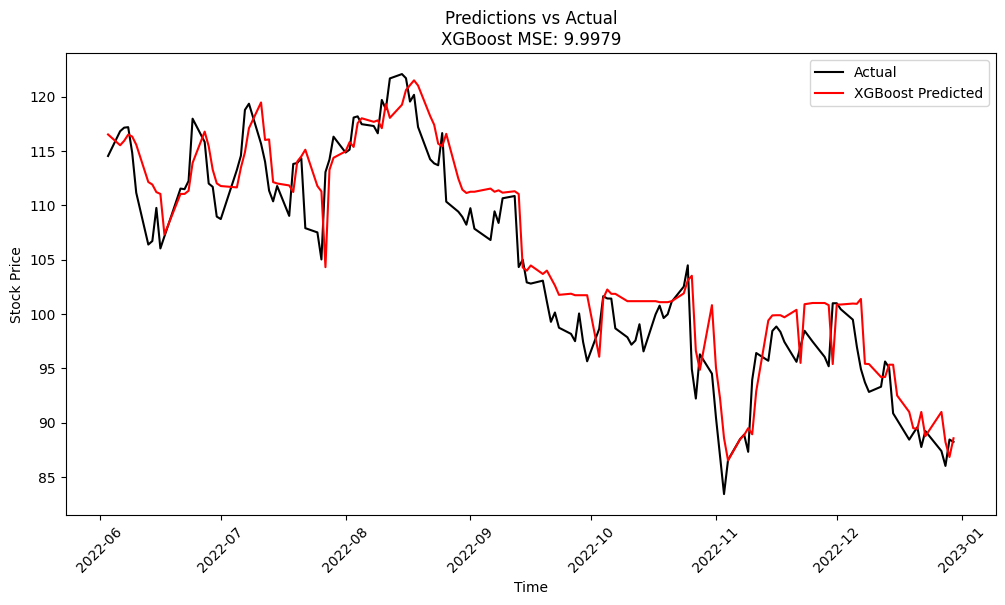

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_orig, label='Actual', color='black')
plt.plot(test_dates, y_pred_xgb, label='XGBoost Predicted', color='red')
plt.legend()
plt.title(f'Predictions vs Actual\nXGBoost MSE: {mse_xgb:.4f}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()